In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import sys
import time
import math
import random
random.seed(0.6)
import matplotlib.pyplot as plt
import pyecharts
from pyecharts.charts import Bar
from pyecharts import options as opts
from pyecharts.charts import Line
from sklearn.ensemble import RandomForestRegressor
import graphviz
from sklearn import tree
from sklearn.datasets import load_wine 
from sklearn.model_selection import train_test_split

print("success")

success


# 1. Read data

In [2]:
train = read_csv('training.csv')
train = train.dropna(axis=0)
display(train.describe())
display(train)

,buying,maint,doors,persons,lug_boot,safety,evaluation
count,1115,1115,1115,1115,1115,1115,1115
unique,4,4,4,3,3,3,2
top,high,vhigh,2,2,small,low,unacc
freq,308,301,298,387,382,408,846


,buying,maint,doors,persons,lug_boot,safety,evaluation
0,high,low,5more,2,med,med,unacc
1,med,low,5more,4,small,low,unacc
2,med,med,4,more,med,low,unacc
3,low,med,3,more,med,low,unacc
4,low,vhigh,3,more,big,low,unacc
...,...,...,...,...,...,...,...
1110,med,vhigh,5more,more,small,low,unacc
1111,vhigh,high,4,4,big,med,unacc
1112,vhigh,high,3,more,med,low,unacc
1113,med,med,4,2,big,med,unacc


In [3]:
test = read_csv('test.csv')
test = test.dropna(axis=0)
display(train.describe())
display(test)

,buying,maint,doors,persons,lug_boot,safety,evaluation
count,1115,1115,1115,1115,1115,1115,1115
unique,4,4,4,3,3,3,2
top,high,vhigh,2,2,small,low,unacc
freq,308,301,298,387,382,408,846


,buying,maint,doors,persons,lug_boot,safety
0,low,vhigh,3,more,med,med
1,vhigh,high,2,more,small,high
2,vhigh,med,5more,4,med,high
3,med,med,5more,4,small,med
4,high,med,4,4,small,high
...,...,...,...,...,...,...
474,low,vhigh,4,4,big,high
475,med,vhigh,3,more,big,high
476,vhigh,low,3,4,big,high
477,med,vhigh,2,2,med,med


# 2. Data Preprocessing

In [4]:
#    buying       v-high, high, med, low
#    maint        v-high, high, med, low
#    doors        2, 3, 4, 5-more
#    persons      2, 4, more
#    lug_boot     small, med, big
#    safety       low, med, high

# Data preprocessing
def classify(x, cls):
        return list(cls).index(x)
def preprocess(df, proportion=.8, if_seperate=True,if_reverse=False):
    rows=df.shape[0]
    col = df.columns.values.tolist()
    # mix the number sequence of rows
    index_list=list(range(rows))
    np.random.shuffle(index_list)
    
    tmp_df=df.copy(deep=True)
    
    #print(mix_df)
    # get the unique coloums
    
    buying=['low','med','high','vhigh']
    maint=['low','med','high','vhigh']
    doors=['2','3','4','5more']
    persons=['2','4','more']
    lug_boot=['small','med', 'big']
    safety=['low','med','high' ]
    if if_reverse:
        evaluation=['unacc', 'acc']
    else:
        evaluation=['acc', 'unacc']
    
#     list_col=['buying','maint','doors','persons','lug_boot','safety','evaluation']
    list_col=list(tmp_df)
#     for each in list_col:
#         ucs.append(each)
    # replace all the df to number
    coloums=0
    for c in list_col:
        true_var=eval(c)
        list_num=list(range(len(true_var)))
        tmp_df[c]=tmp_df[c].replace(true_var,list_num)
    
    
    # store the df in random line
    mix_df = tmp_df.iloc[index_list]
    
    p_train = int(np.floor(rows * proportion))
    training = mix_df.iloc[:p_train]
    testing = mix_df.iloc[p_train:]
    if if_seperate:
        return training, testing
    else:
        # eturns data that has been processed but not out of order
        return tmp_df
# separate the dataframe into 4 pieces

def separate_df(df, proportion=.8,if_reverse=False):
    training, testing=preprocess(df, proportion,True,if_reverse)
    train_x=training.iloc[:,:-1]
    train_y=training.iloc[:,-1]
    test_x=testing.iloc[:,:-1]
    test_y=testing.iloc[:,-1]
    return train_x,train_y,test_x,test_y

# restore the orginal data
def restore(rev):
    buying=['low','med','high','vhigh']
    maint=['low','med','high','vhigh']
    doors=['2','3','4','5more']
    persons=['2','4','more']
    lug_boot=['small','med', 'big']
    safety=['low','med','high' ]
    evaluation=['unacc', 'acc']
    predict=['unacc', 'acc']
        
    list_col=list(rev)
    for coll in list_col:
        true_var=eval(coll)
        list_num=list(range(len(true_var)))
#         print(list_num)
#         print(true_var)
        rev[coll]=rev[coll].replace(list_num,true_var)
    return rev

# round the array to what we want
def round_list(float_list,round_num):
    # let it become array
    mid_np = np.array(float_list)                    
    # round it
    mid_np_2f = np.round(mid_np,round_num)
    # change the float_list
    list_new = list(mid_np_2f)                    
    return list_new

# 3. Index function

In [5]:
# the output is accur,precision,recall,F_score
def cor_percentage(pred,actual,B2=1):   #input should be pd.series
    try:
        # solve the problem caused by transer to series from array
        pred=pd.Series(pred.tolist())
        actual=pd.Series(actual.tolist())
        # get the row of row number of dataframe
        df_row_num=len(actual)

        # get the accuracy
        pred_actual=abs(pred-actual)
        same_num=df_row_num-sum(pred_actual)
        accur=same_num/df_row_num

        pred_sum=sum(pred)
        actual_sum=sum(actual)
        
        # get the Precision and recall
        same1_count=0
        add_list=np.array(pred+actual)
        same1_count=len(add_list[add_list > 1])

        precision=(same1_count)/(pred_sum)
        recall=(same1_count)/(actual_sum)

        F_score=((1+B2)*precision*recall)/(recall+precision*B2)

        return accur,precision,recall,F_score
    except:
        return 0,0,0,0

# 4. Decision tree

In [6]:
def test_DT(display_tree,if_rev=False):
    # get the data
    train_x,train_y,test_x,test_y=separate_df(train,if_reverse=if_rev)

    start=time.time()
    #use parameters to instantiate an algorithm object
    clf = tree.DecisionTreeClassifier()
    #Training model with training set data
    clf = clf.fit(train_x,train_y) 
    end=time.time()
    print("Time cost for training: "+ str(end-start))

    # import the test set to score
    result = clf.score(test_x,test_y)

    #Predict returns the classification or regression results of each test sample
    pre=clf.predict(test_x)

    pre=pd.Series(pre)
    actual=pd.Series(test_y.tolist())

    if display_tree:
        # make a decision table
        feature_name = train_x.columns
        dot_data = tree.export_graphviz(clf,out_file = None,feature_names= feature_name,class_names=['acc', 'unacc'],filled=True,rounded=True)
        graph = graphviz.Source(dot_data)
        display(graph)
    
    return cor_percentage(pre,actual)

Make a test for average Accuarcy, Precision, Recall, F_score in normal data

In [7]:
if_re=True
display_tree=False
times=10
tmp_Accuarcy=[]
tmp_Precision=[]
tmp_Recall=[]
tmp_F_score=[]
for i in range(times):
    restult_each=test_DT(display_tree,if_re)
    tmp_Accuarcy.append(restult_each[0])
    tmp_Precision.append(restult_each[1])
    tmp_Recall.append(restult_each[2])
    tmp_F_score.append(restult_each[3])
    
A_tmp=sum(tmp_Accuarcy)/(times)
P_tmp=sum(tmp_Precision)/(times)
R_tmp=sum(tmp_Recall)/(times)
F_tmp=sum(tmp_F_score)/(times)

nor_score=[A_tmp,P_tmp,R_tmp,F_tmp]

print("The 10 times average for Accuarcy, Precision, Recall, F_score is:")
print(A_tmp,end=" ")
print(P_tmp,end=" ")
print(R_tmp,end=" ")
print(F_tmp,end=" ")

Time cost for training: 0.0029985904693603516
Time cost for training: 0.001998424530029297
Time cost for training: 0.0019996166229248047
Time cost for training: 0.0019998550415039062
Time cost for training: 0.0020012855529785156
Time cost for training: 0.002000093460083008
Time cost for training: 0.002000093460083008
Time cost for training: 0.003001689910888672
Time cost for training: 0.0020012855529785156
Time cost for training: 0.002000093460083008
The 10 times average for Accuarcy, Precision, Recall, F_score is:
0.9807174887892376 0.9622909572125282 0.9555961507217562 0.9583958520369611 

The tree it make

Time cost for training: 0.003000974655151367


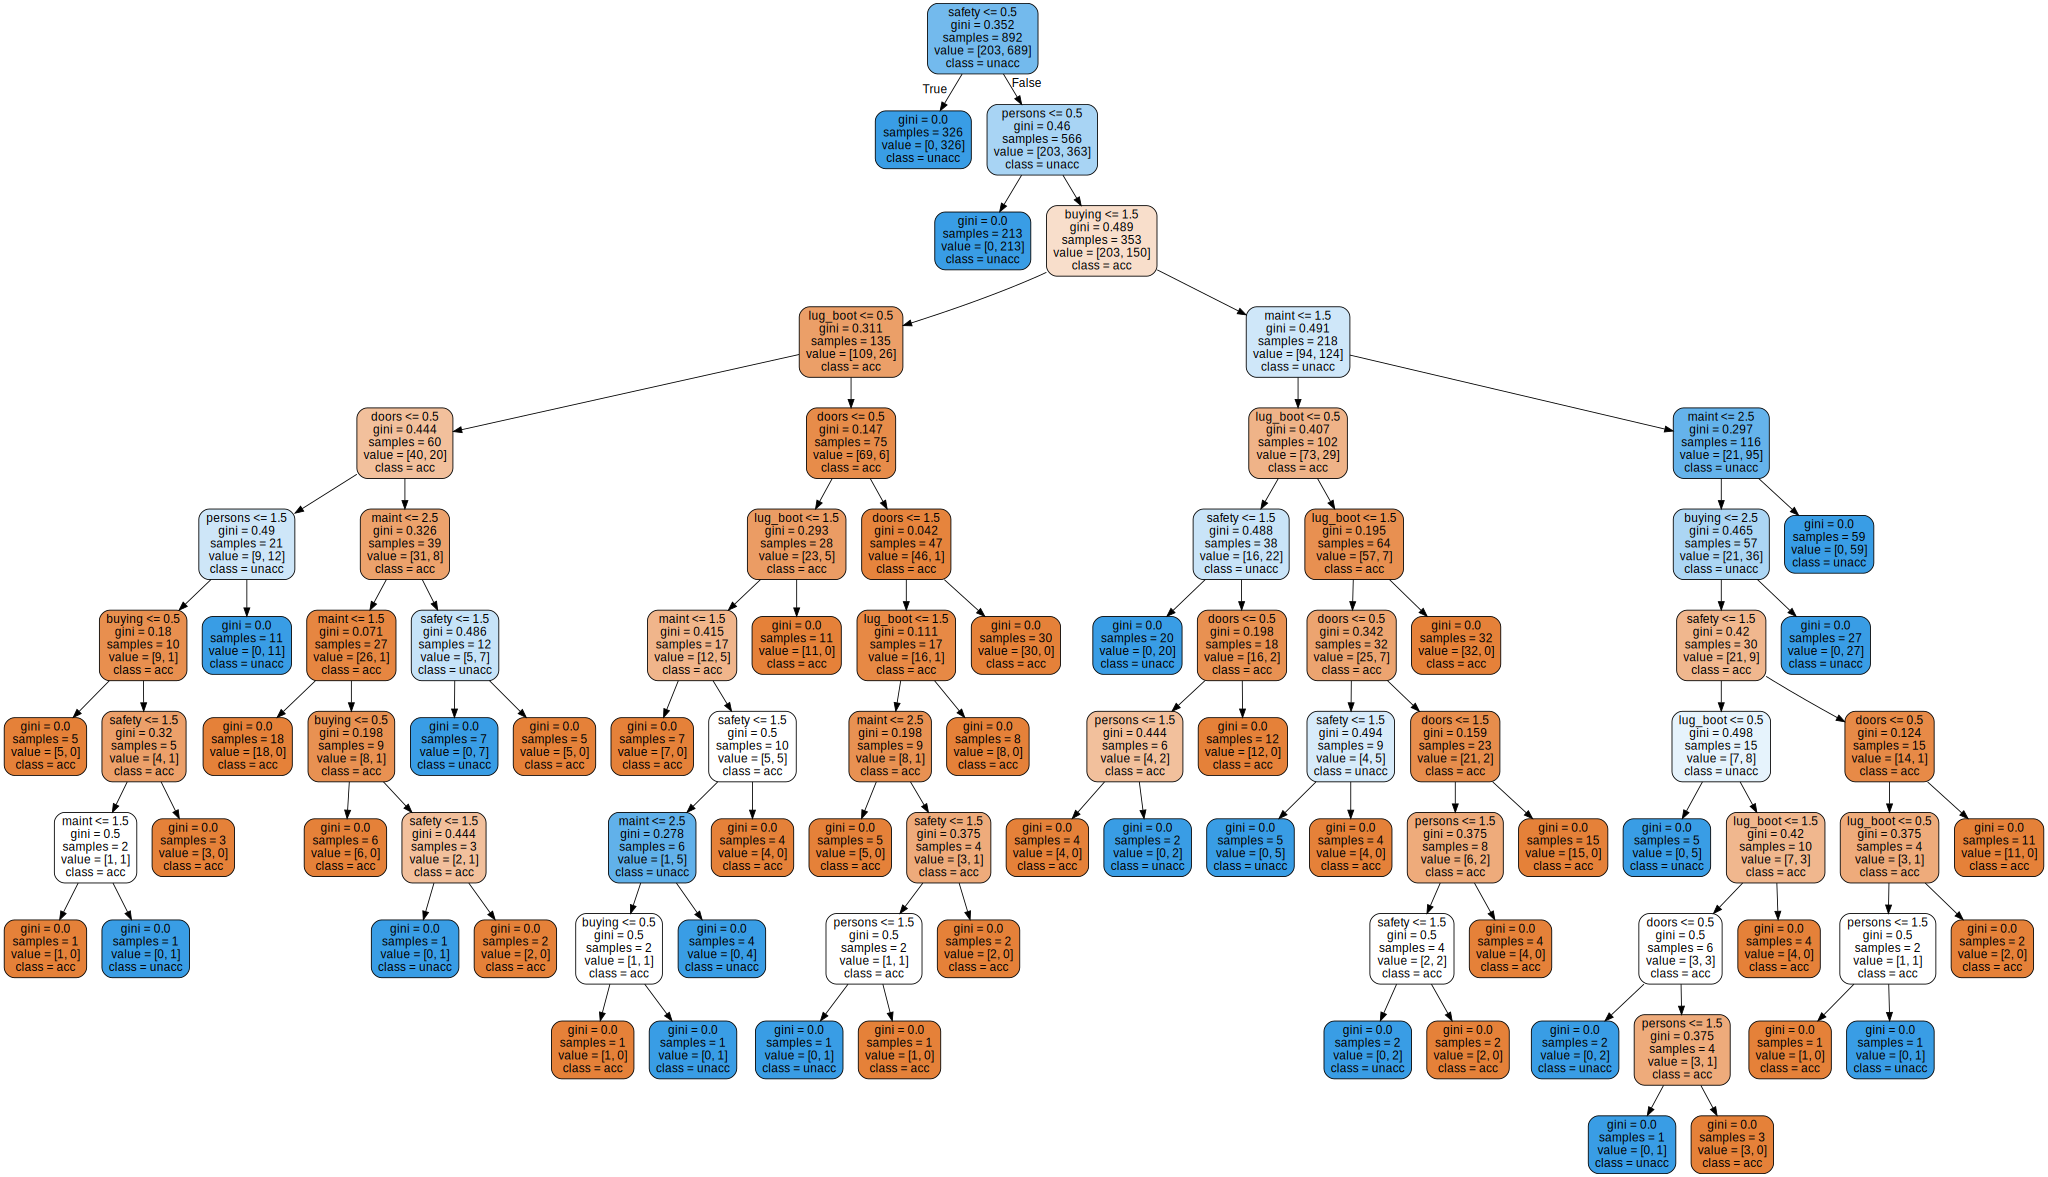

(0.9910313901345291,
 0.9936305732484076,
 0.9936305732484076,
 0.9936305732484076)

In [8]:
if_re=False
display_tree=True
test_DT(display_tree,if_re)

Make a test for average Accuarcy, Precision, Recall, F_score in reverse data

In [9]:
if_re=True
display_tree=False
times=10
tmp_Accuarcy=[]
tmp_Precision=[]
tmp_Recall=[]
tmp_F_score=[]
for i in range(times):
    restult_each=test_DT(display_tree,if_re)
    tmp_Accuarcy.append(restult_each[0])
    tmp_Precision.append(restult_each[1])
    tmp_Recall.append(restult_each[2])
    tmp_F_score.append(restult_each[3])
    
A_tmp=sum(tmp_Accuarcy)/(times)
P_tmp=sum(tmp_Precision)/(times)
R_tmp=sum(tmp_Recall)/(times)
F_tmp=sum(tmp_F_score)/(times)

rev_score=[A_tmp,P_tmp,R_tmp,F_tmp]

print("The 10 times average for Accuarcy, Precision, Recall, F_score is:")
print(A_tmp,end=" ")
print(P_tmp,end=" ")
print(R_tmp,end=" ")
print(F_tmp,end=" ")

Time cost for training: 0.0029990673065185547
Time cost for training: 0.0019998550415039062
Time cost for training: 0.003998279571533203
Time cost for training: 0.004000186920166016
Time cost for training: 0.0029997825622558594
Time cost for training: 0.0049991607666015625
Time cost for training: 0.002999544143676758
Time cost for training: 0.0029954910278320312
Time cost for training: 0.002999544143676758
Time cost for training: 0.004999876022338867
The 10 times average for Accuarcy, Precision, Recall, F_score is:
0.9820627802690582 0.9635126318438983 0.9617383319702574 0.9622029422249984 

The tree it make

Time cost for training: 0.002000570297241211


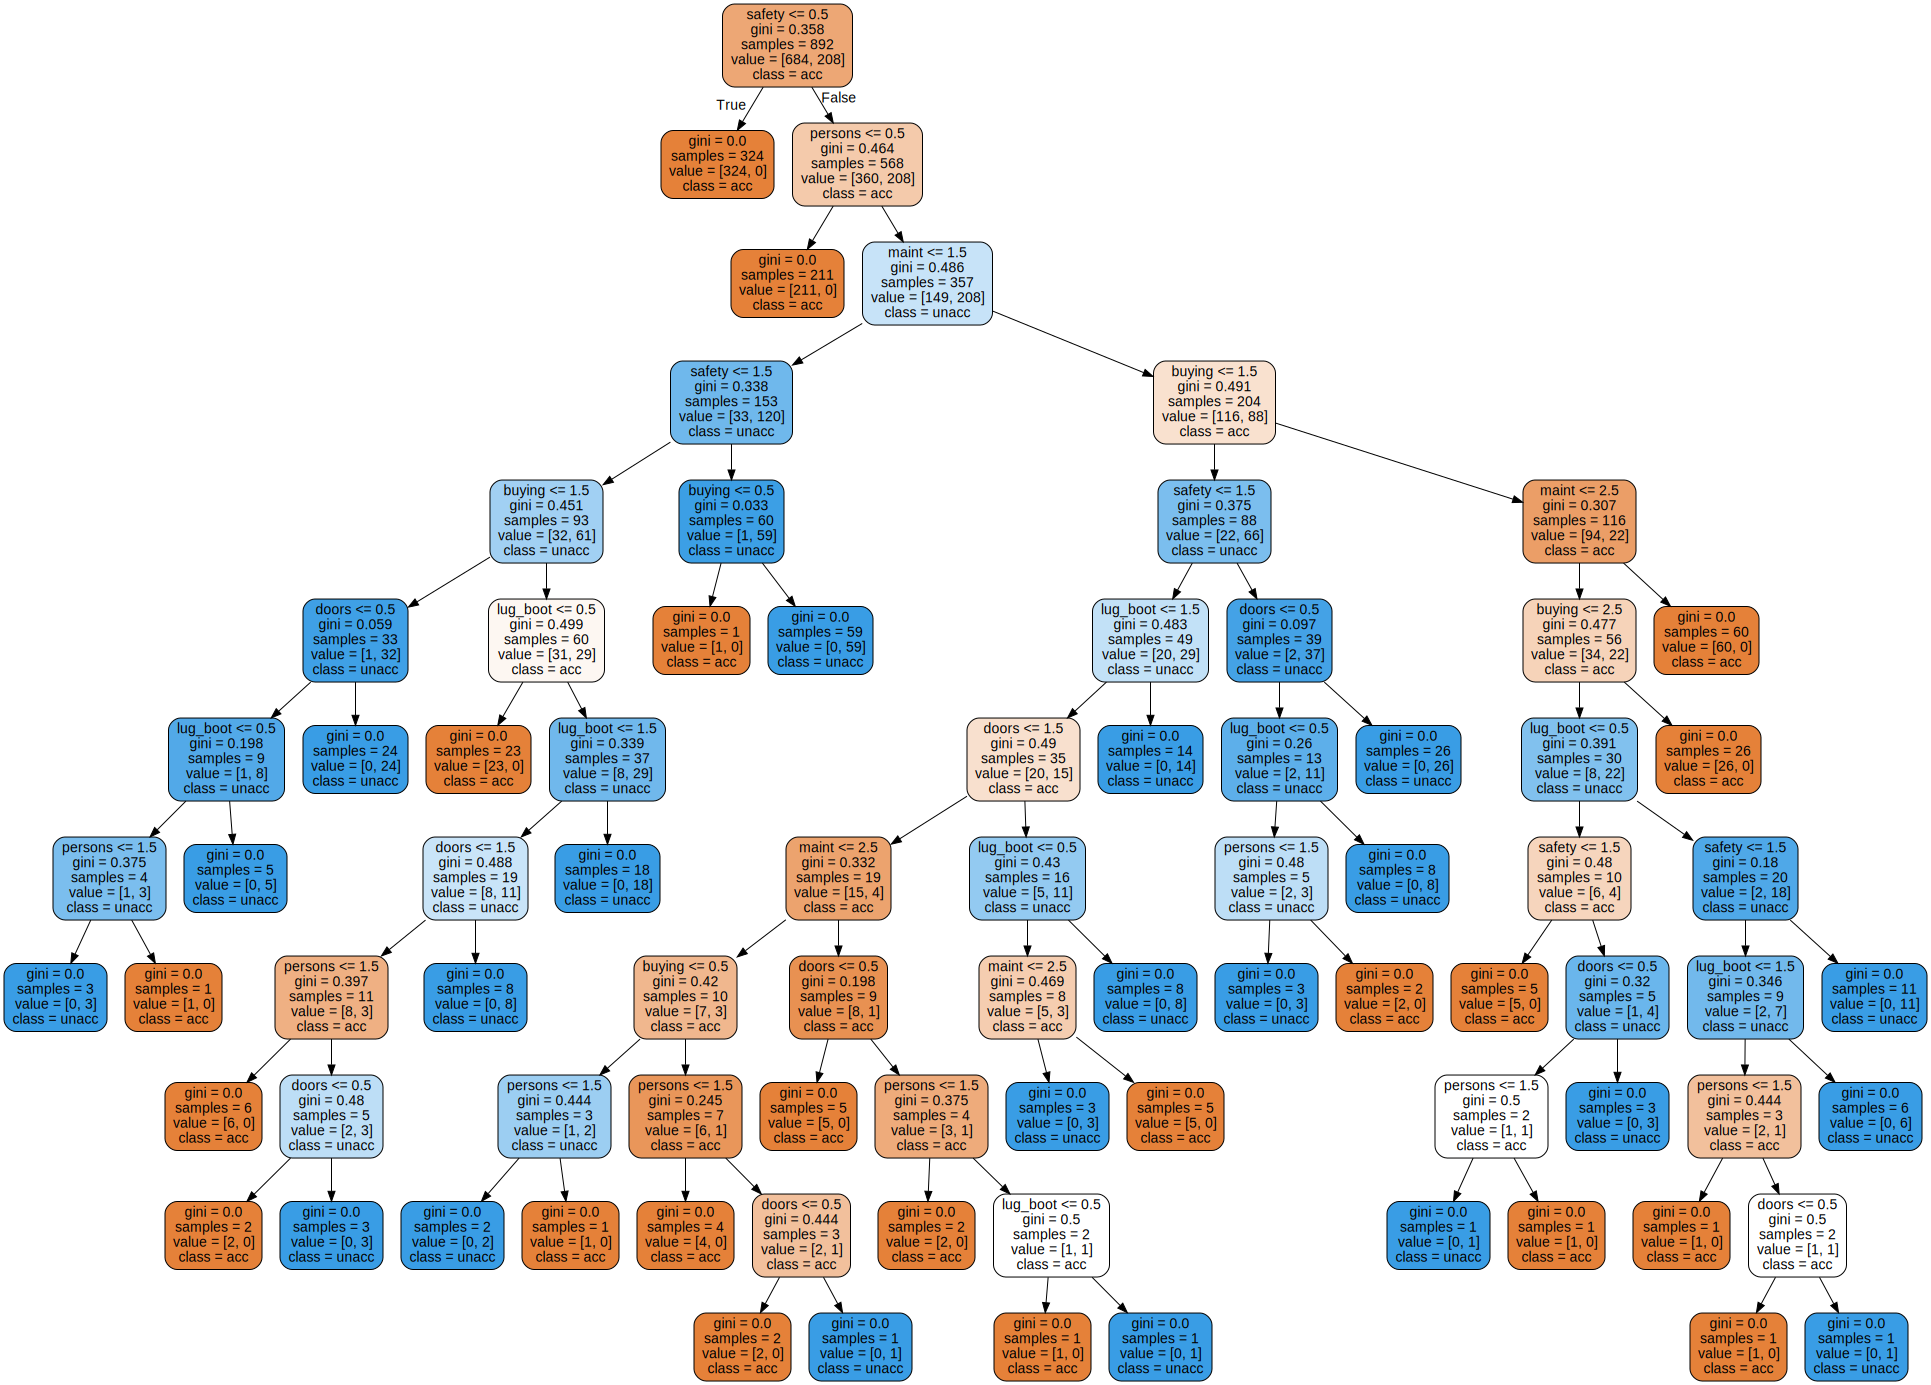

(0.9730941704035875,
 0.9365079365079365,
 0.9672131147540983,
 0.9516129032258064)

In [10]:
if_re=True
display_tree=True
test_DT(display_tree,if_re)

Overview

In [11]:
# Over view
method_list=['no_reverse','reverse']
score=['Accuarcy', 'Precision', 'Recall', 'F_score']
round_num=3
n_s=round_list(nor_score,round_num)
r_s=round_list(rev_score,round_num)
       
bar = Bar()
bar.add_xaxis(method_list)
for i in range(len(score)):
    tmp=[]
    tmp.append(n_s[i])
    tmp.append(r_s[i])
#     display(tmp)
#     display(score[i])
    
    # draw a graph
    name=str(score[i])
    bar.add_yaxis(name, tmp)

bar.set_global_opts(title_opts=opts.TitleOpts(title="Random forest",subtitle="Average score for the data in normal and reverse data"))
bar.render_notebook()

## Relation between max depth and the score 

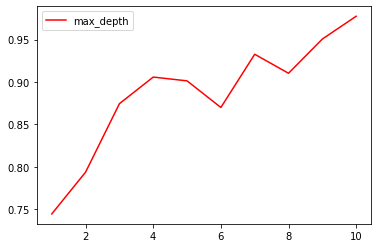

In [12]:
test=[]
# get the data
for i in range(10): 
    train_x,train_y,test_x,test_y=separate_df(train)
    clf = tree.DecisionTreeClassifier(max_depth=i+1,criterion="entropy",random_state=30,splitter="random") 
    clf = clf.fit(train_x, train_y) 
    score = clf.score(test_x, test_y) 
    test.append(score) 
# put the score in the graph
plt.plot(range(1,11),test,color="red",label="max_depth") 
plt.legend()
plt.show()

Both data seems to have good performance

# 5. Get the result

In [13]:
# get the data
train_x,train_y,test_x,test_y=separate_df(train)
test_pro_x=preprocess(test, proportion=.8, if_seperate=False,if_reverse=False)

start=time.time()
#use parameters to instantiate an algorithm object
clf = tree.DecisionTreeClassifier()
#Training model with training set data
clf = clf.fit(train_x,train_y) 
end=time.time()
print("Time cost for training: "+ str(end-start))

# import the test set to score
result = clf.score(test_x,test_y)

#Predict returns the classification or regression results of each test sample
pre=clf.predict(test_pro_x)

pre_result=test_pro_x.assign(predict=pd.Series(pre).values)

pre_result
final_result=restore(pre_result)
display(final_result)
final_result.to_csv("Decision tree.csv")

AttributeError: 'list' object has no attribute 'shape'